In [ ]:
import gensim
import numpy as np
import nltk
import pandas as pd 
from tqdm import tqdm
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
import nltk
from nltk.stem.lancaster import LancasterStemmer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from keras_preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, log_loss 
from sklearn.model_selection import StratifiedKFold
from nltk.corpus import stopwords 
import re 
import seaborn as sns
import matplotlib.pyplot as plt

# **데이터 전처리**

In [ ]:
#데이터 불러오기

train_dataset = pd.read_csv("/content/train.csv",encoding='utf-8') 
test_dataset = pd.read_csv("/content/test_x.csv",encoding='utf-8')

In [ ]:
#데이터 중에 불어를 영어로 번역하기

#번역해 줄 dictionary
translate_user_dict = {"_un doigt d'eau de vie_.":"a finger of brandy", "Oui, j'ai pris un mot pour un autre.":"Yes, I took one word for another.", "Mais c'est égal.":"But it doesn't matter.", "Oui, j'ai beaucoup à vous dire, chère amie.":"Yes, I have a lot to tell you, dear friend.", "parce que nous avons à parler.":"because we have to talk.", "Pardon, j'ai oublié son nom.":"Sorry, I forgot his name.", "Il n'est pas du pays":"He is not from the country", "quelque chose de bête et d'Allemand dans la physionomie.":"something stupid and German in the physiognomy.", "C'est encore mieux":"It's even better", "j'ai en tout quarante roubles mais":"I have forty rubles in all but", "Grace à Dieu":"Thanks to God", "c'est une si pauvre tête!":"that is such a poor head!", "c'est un pauvre sire, tout de même":"he is a poor sire, all the same", "et puis":"and then", "c'est très":"it's very", "c'est rassurant au plus haut degré.":"that is reassuring to the highest degree.", "Elle me soupçonnera toute sa vie":"She will suspect me all her life", "c'est égal":"is equal", "L'Evangile... voyez-vous, désormais nous prêcherons ensemble":"The Gospel ... see, from now on we will preach together", "c'est admis":"it is admitted", "chère innocente":"dear innocent", "et à cette chère ingrate":"and to this dear ungrateful", "c'est un ange":"it's an angel", "cette pauvre_ auntie":"this poor auntie", "Cap'n":"captain", "jawing--v'yages":"jawing - travels", "a'terwards":"afterwards", "m'clour":"to me", "ma'am":"madam", "Oh, hier il avait tant d'esprit":"Oh, yesterday he had so much wit","d'eau de vie_":"brandy_",
"C'est un pense-creux d'ici":"It's a reminder of here",
"Je n'ai rien contre l'Evangile":"I have nothing against the Gospel",
"C'est le meilleur et le plus irascible homme du monde.":"He's the best and most irascible man in the world.", 
"_C'est un ange; c'était plus qu'un ange pour moi.":"_It's an angel; it was more than an angel to me."}

In [ ]:
keys = list(translate_user_dict.keys()) 
keys_with_length = [(key, len(key)) for key in keys]

In [ ]:
sorted_keys = sorted(keys_with_length, key=lambda x : -x[1]) 
sorted_keys = [ key[0] for key in sorted_keys] 
sorted_keys

["L'Evangile... voyez-vous, désormais nous prêcherons ensemble",
 "quelque chose de bête et d'Allemand dans la physionomie.",
 "C'est le meilleur et le plus irascible homme du monde.",
 "_C'est un ange; c'était plus qu'un ange pour moi.",
 "Oui, j'ai beaucoup à vous dire, chère amie.",
 "Oui, j'ai pris un mot pour un autre.",
 "c'est rassurant au plus haut degré.",
 "j'ai en tout quarante roubles mais",
 "c'est un pauvre sire, tout de même",
 'Elle me soupçonnera toute sa vie',
 "Oh, hier il avait tant d'esprit",
 'parce que nous avons à parler.',
 "Je n'ai rien contre l'Evangile",
 "Pardon, j'ai oublié son nom.",
 "C'est un pense-creux d'ici",
 "c'est une si pauvre tête!",
 "_un doigt d'eau de vie_.",
 'et à cette chère ingrate',
 "Il n'est pas du pays",
 'cette pauvre_ auntie',
 "C'est encore mieux",
 "Mais c'est égal.",
 'chère innocente',
 "jawing--v'yages",
 "c'est un ange",
 "d'eau de vie_",
 'Grace à Dieu',
 "c'est admis",
 "c'est très",
 "c'est égal",
 "a'terwards",
 'et puis',

In [ ]:
#불어(프랑스어) 찾아서 데이터 수정하기
cnt = 0 
text_list = list(train_dataset['text']) 

for i in tqdm(range(len(sorted_keys))): 
  for j in range(len(text_list)): 
    if sorted_keys[i] in text_list[j]: 
      text_list[j] = text_list[j].replace(sorted_keys[i], translate_user_dict[sorted_keys[i]]) 
      cnt = cnt + 1

print("{}번 수정되었습니다.".format(cnt))


cnt = 0 
text_list2 = list(test_dataset['text']) 
for i in tqdm(range(len(sorted_keys))): 
  for j in range(len(text_list2)): 
    if sorted_keys[i] in text_list2[j]: 
      text_list2[j] = text_list2[j].replace(sorted_keys[i], translate_user_dict[sorted_keys[i]]) 
      cnt = cnt + 1 
print("{}번 수정되었습니다.".format(cnt))

 20%|██        | 7/35 [00:00<00:00, 69.99it/s]

156번 수정되었습니다.


100%|██████████| 35/35 [00:00<00:00, 60.92it/s]

42번 수정되었습니다.


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#불용어 list 만들기
nltk.download("stopwords") 
nltk.download("punkt") 

stopwords_list=[]
with open('/content/stop_words_english.txt', 'r', encoding='utf-8') as file:
    for line in file.readlines():
        stopwords_list.append(line.rstrip())
        
stopwords_list = stopwords_list + stopwords.words("english") 
stopwords = list(set(stopwords_list))

# 불용어 제거 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train_dataset['clear_text']=text_list
test_dataset['clear_text']=text_list2
#소문자로 갱신
train_dataset['clear_text'] = train_dataset['clear_text'].str.lower().apply(remove_stopwords)
test_dataset['clear_text'] = test_dataset['clear_text'].str.lower().apply(remove_stopwords)

In [ ]:
#부호 제거 함수

list1=[]
def get_clean_text_list(data_df):
  plain_text_list = list(data_df['clear_text']) 
  clear_text_list = [] 
  count=0
  for i in tqdm(range(len(plain_text_list))): 
    plain_text = plain_text_list[i] 
    clear_text = plain_text.replace("\\", "").replace("\n", "") 
    clear_text = re.sub(r'[^A-Za-z0-9 ]', '', clear_text)
    if clear_text.split() == []:
        count += 1
        list1.append(i)
    clear_text_list.append(clear_text.lower()) 
  print(f"학습 데이터 중 빈 문장의 갯수 : {count}")
  return clear_text_list

In [ ]:
train_dataset['clear_text'] = get_clean_text_list(train_dataset) 
test_dataset['clear_text'] = get_clean_text_list(test_dataset)

 46%|████▌     | 9038/19617 [00:00<00:00, 90377.50it/s]

학습 데이터 중 빈 문장의 갯수 : 44


100%|██████████| 19617/19617 [00:00<00:00, 82121.74it/s]

학습 데이터 중 빈 문장의 갯수 : 0


In [ ]:
train_dataset['clear_text'].replace('    ', np.nan, inplace=True)
train_dataset.dropna(subset=['clear_text'], inplace=True)
train_dataset=train_dataset.reset_index(drop=True)
train_dataset=train_dataset.drop(['index'],axis=1)

**표제화도 시도했지만 좋지 못한 결과를 도출했다.**

train 데이터 표제화 및 단어 길이가 2개 이상만 남기기

In [ ]:
# from nltk.tokenize import word_tokenize 
# X_train = []
# Y_train=[]
# train_text1=[] 
# train_clear_text = list(train_dataset['clear_text']) 
# stemmer = WordNetLemmatizer() #love와 loves 같은 뜻이므로 이런 것을 하나로 통합을 위해서
#                                 #표제어 추출로 기본형으로 바꿔준다

# for i in tqdm(range(len(train_clear_text))): 
#   temp = word_tokenize(train_clear_text[i]) 
#   #temp = [word for word in temp if word not in stopwords_list]
#   temp = [stemmer.lemmatize(temps) for temps in temp] #여기에서 표제어 추출하는 이유는 'gentlemen!' 이렇게 붙으면 gentleman!이 아닌 gentlemen!으로 표기함 
#   temp = [word for word in temp if len(word) > 1]
#   if temp != []:
#     wo=temp[0]
#     for j in range(1,len(temp)):
#       wo=wo+' '+temp[j]
#     train_text1.append(wo)
#     Y_train.append(train_dataset.loc[i,'author'])
#   X_train.append(temp)

In [ ]:
# X_test = [] 
# test_text1=[]
# test_clear_text = list(test_dataset['clear_text']) 
# stemmer = WordNetLemmatizer() #love와 loves 같은 뜻이므로 이런 것을 하나로 통합을 위해서
#                                 #표제어 추출로 기본형으로 바꿔준다

# for i in tqdm(range(len(test_clear_text))): 
#   temp = word_tokenize(test_clear_text[i]) 
#   #temp = [word for word in temp if word not in stopwords_list] 
#   temp = [stemmer.lemmatize(temps) for temps in temp] #여기에서 표제어 추출하는 이유는 'gentlemen!' 이렇게 붙으면 gentleman!이 아닌 gentlemen!으로 표기함 
#   temp = [word for word in temp if len(word) > 1]
#   wo=temp[0]
#   for j in range(1,len(temp)):
#     wo=wo+' '+temp[j]
#   test_text1.append(wo)
#   X_test.append(temp)

In [ ]:
X_train = np.array([x for x in train_dataset['text']])
X_test = np.array([x for x in test_dataset['text']])
y_train = np.array([x for x in train_dataset['author']])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


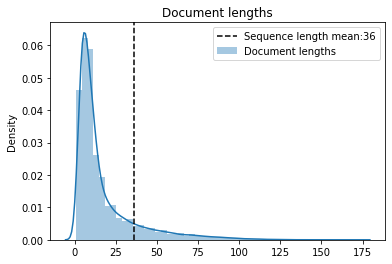

 가장 긴 문장은 173 개의 단어를, 평균 문장은 17.206255129023432 개의 단어를, 가장 짧은 문장은 1 개의 단어를 가지고 있습니다.


In [ ]:
train_dataset['doc_len'] = train_dataset['clear_text'].apply(lambda x : len(x.split()))

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.doc_len.mean() + dataframe.doc_len.std()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{max_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train_dataset['doc_len'].max()} 개의 단어를, 평균 문장은 {train_dataset['doc_len'].mean()} 개의 단어를, 가장 짧은 문장은 {train_dataset['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train_dataset)

#이것을 봤을 때, 앞으로 max_len을 173로 잡을 것이다.

# **토큰화 및 패딩**

In [ ]:
embedding_dim=300
max_length=173
padding_type='post'

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) 
word_index = tokenizer.word_index

vocab_size=len(word_index)+1 #vocabulary 크기 설정
print(vocab_size)

42331


In [ ]:
from keras_preprocessing.sequence import pad_sequences 

#데이터를 sequence로 변환하고 padding 해주기
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length) 

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

print(train_padded.shape, test_padded.shape)

(54835, 173) (19617, 173)


# **Word2vec 임베딩**

In [ ]:
#사전 훈련된 word2vec 불러오기
word2vecm = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True)

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300)) #300차원의 임베딩 매트릭스 생성

# 모델의 크기 확인
print("모델 크기: ",word2vecm.vectors.shape) # 사전에 정의된 word2vec모델은 총 3000000개 단어가 300차원을 가진 벡터로 매핑되어 있다.
 

print(np.shape(embedding_matrix))
 
def get_vector(word):
    if word in word2vecm:
        return word2vecm[word]
    else:
        return None
 
for word, i in t.word_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None: # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.

print("embedding matrix 크기:",embedding_matrix.shape)

모델 크기: (3000000, 300)
(16, 300)
embedding matrix 크기:(42331, 300)


# **Bi-LSTM모델**

## **Adam의 learning rate가 0.003일 경우**

In [ ]:
n_fold = 5
n_class = 5
seed = 42

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

#Bi-LSTM 모델 구축
model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(5, activation='softmax')
])
    
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.003))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 173, 300)          12699300  
_________________________________________________________________
bidirectional (Bidirectional (None, 173, 128)          186880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 12,985,641
Trainable params: 12,985,641
Non-trainable params: 0
_________________________________________________________________


데이터가 편항되어 있을 경우(몰려있을 경우) 단순 k-겹 교차검증을 사용하면 성능 평가가 잘 되지 않을 수 있다. 따라서 이럴 땐 stratified k-fold cross-validation을 사용

In [ ]:
#모델 훈련
p_val = np.zeros((train_padded.shape[0], 5))
p_tst = np.zeros((test_padded.shape[0], 5))
for i, (i_trn, i_val) in enumerate(cv.split(train_padded, y_train), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()  
    #clf=model  
    clf.fit(train_padded[i_trn], 
            to_categorical(y_train[i_trn]),
            validation_data=(train_padded[i_val], to_categorical(y_train[i_val])),
            epochs=15,
            batch_size=128,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(train_padded[i_val])
    p_tst += clf.predict(test_padded) / n_fold

training model for CV #1
Epoch 1/15
343/343 [==============================] - 90s 159ms/step - loss: 1.1755 - val_loss: 0.7782
Epoch 2/15
343/343 [==============================] - 55s 161ms/step - loss: 0.5676 - val_loss: 0.6682
Epoch 3/15
343/343 [==============================] - 53s 155ms/step - loss: 0.4216 - val_loss: 0.7432
Epoch 4/15
343/343 [==============================] - 53s 156ms/step - loss: 0.3407 - val_loss: 0.7313
Epoch 5/15
343/343 [==============================] - 54s 157ms/step - loss: 0.2926 - val_loss: 0.7231
Epoch 6/15
343/343 [==============================] - 54s 157ms/step - loss: 0.2853 - val_loss: 0.7453
Epoch 7/15
343/343 [==============================] - 54s 157ms/step - loss: 0.2495 - val_loss: 0.8765
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
training model for CV #2
Epoch 1/15
343/343 [==============================] - 59s 159ms/step - loss: 1.1993 - val_loss: 0.7814
Epoch 2/15
343/343 [======================

In [ ]:
print("Bi-LSTM모델과 learning rate 0.003을 적용한 정확도와 log_loss")
print(accuracy_score(y_train, np.argmax(p_val, axis=1)) * 100)
print(log_loss(pd.get_dummies(y_train), p_val))

Bi-LSTM모델과 learning rate 0.003을 적용한 정확도와 log_loss
73.47012336230615
0.7132


## **Adam의 learning rate가 0.005일 경우**

In [ ]:
n_fold = 5
n_class = 5
seed = 42

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

#Bi-LSTM 모델 구축
model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(5, activation='softmax')
])
    
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.005))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 173, 300)          12699300  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 173, 128)          186880    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 12,985,641
Trainable params: 12,985,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#모델 훈련
p_val = np.zeros((train_padded.shape[0], 5))
p_tst = np.zeros((test_padded.shape[0], 5))
for i, (i_trn, i_val) in enumerate(cv.split(train_padded, y_train), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()  
    #clf=model  
    clf.fit(train_padded[i_trn], 
            to_categorical(y_train[i_trn]),
            validation_data=(train_padded[i_val], to_categorical(y_train[i_val])),
            epochs=15,
            batch_size=128,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(train_padded[i_val])
    p_tst += clf.predict(test_padded) / n_fold

training model for CV #1
Epoch 1/15
343/343 [==============================] - 88s 159ms/step - loss: 1.1643 - val_loss: 0.8635
Epoch 2/15
343/343 [==============================] - 85s 161ms/step - loss: 1.0285 - val_loss: 0.7496
Epoch 3/15
343/343 [==============================] - 85s 155ms/step - loss: 0.8646 - val_loss: 0.7203
Epoch 4/15
343/343 [==============================] - 85s 156ms/step - loss: 0.7465 - val_loss: 0.7192
Epoch 5/15
343/343 [==============================] - 85s 157ms/step - loss: 0.6579 - val_loss: 0.7251
Epoch 6/15
343/343 [==============================] - 85s 157ms/step - loss: 0.5186 - val_loss: 0.7569
Epoch 7/15
343/343 [==============================] - 85s 157ms/step - loss: 0.3953 - val_loss: 0.8535
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
training model for CV #2
Epoch 1/15
343/343 [==============================] - 85s 159ms/step - loss: 1.1325 - val_loss: 0.8345
Epoch 2/15
343/343 [======================

In [ ]:
print("Bi-LSTM모델과 learning rate 0.005을 적용한 정확도와 log_loss")
print(accuracy_score(y_train, np.argmax(p_val, axis=1)) * 100)
print(log_loss(pd.get_dummies(y_train), p_val))

Bi-LSTM모델과 learning rate 0.005을 적용한 정확도와 log_loss
74.581493929423
0.7073


## **Adam의 learning rate가 0.007일 경우**

In [ ]:
#Bi-LSTM 모델 구축
n_fold = 5
n_class = 5
seed = 42

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(5, activation='softmax')
])
    
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.007))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 173, 300)          12699300  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 173, 128)          186880    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 12,985,641
Trainable params: 12,985,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#모델 훈련
p_val = np.zeros((train_padded.shape[0], 5))
p_tst = np.zeros((test_padded.shape[0], 5))
for i, (i_trn, i_val) in enumerate(cv.split(train_padded, y_train), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()  
    #clf=model  
    clf.fit(train_padded[i_trn], 
            to_categorical(y_train[i_trn]),
            validation_data=(train_padded[i_val], to_categorical(y_train[i_val])),
            epochs=15,
            batch_size=128,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(train_padded[i_val])
    p_tst += clf.predict(test_padded) / n_fold

training model for CV #1
Epoch 1/15
343/343 [==============================] - 81s 161ms/step - loss: 1.0493 - val_loss: 0.8795
Epoch 2/15
343/343 [==============================] - 81s 163ms/step - loss: 0.8562 - val_loss: 0.8132
Epoch 3/15
343/343 [==============================] - 81s 163ms/step - loss: 0.8435 - val_loss: 0.7835
Epoch 4/15
343/343 [==============================] - 81s 163ms/step - loss: 0.7953 - val_loss: 0.7649
Epoch 5/15
343/343 [==============================] - 82s 164ms/step - loss: 0.7304 - val_loss: 0.7453
Epoch 6/15
343/343 [==============================] - 82s 164ms/step - loss: 0.6034 - val_loss: 0.7204
Epoch 7/15
343/343 [==============================] - 81s 164ms/step - loss: 0.5052 - val_loss: 0.8129
Epoch 8/15
343/343 [==============================] - 81s 164ms/step - loss: 0.4734 - val_loss: 0.8849
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
training model for CV #2
Epoch 1/15
343/343 [======================

In [ ]:
print("Bi-LSTM모델과 learning rate 0.007을 적용한 정확도와 log_loss")
print(accuracy_score(y_train, np.argmax(p_val, axis=1)) * 100)
print(log_loss(pd.get_dummies(y_train), p_val))

Bi-LSTM모델과 learning rate 0.007을 적용한 정확도와 log_loss
74.85012668252956
0.7021


# **CNN모델**

## **Adam의 learning rate가 0.003일 경우(활성화 함수 relu)**

In [ ]:
n_fold = 5
n_class = 5
seed = 42

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

model = Sequential([
                    Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length),
                    Dropout(.5),
                    Conv1D(128, 7, padding="valid", activation="relu", strides=3),
                    Conv1D(128, 7, padding="valid", activation="relu", strides=3),    
                    GlobalMaxPooling1D(),
                    Dense(128, activation='relu'),
                    Dropout(.5),
                    Dense(n_class, activation='softmax')
                   ])

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=.003))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 173, 300)          12699300  
_________________________________________________________________
dropout_4 (Dropout)          (None, 173, 300)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 56, 128)           268928    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 17, 128)           114816    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [ ]:
p_val = np.zeros((train_padded.shape[0], n_class))
p_tst = np.zeros((test_padded.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(train_padded, y_train), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()    
    clf.fit(train_padded[i_trn], 
            to_categorical(y_train[i_trn]),
            validation_data=(train_padded[i_val], to_categorical(y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(train_padded[i_val])
    p_tst += clf.predict(test_padded) / n_fold

training model for CV #1
Epoch 1/15
343/343 [==============================] - 95s 158ms/step - loss: 1.2351 - val_loss: 1.0246
Epoch 2/15
343/343 [==============================] - 94s 158ms/step - loss: 0.9824 - val_loss: 0.8593
Epoch 3/15
343/343 [==============================] - 94s 158ms/step - loss: 0.8942 - val_loss: 0.8332
Epoch 4/15
343/343 [==============================] - 94s 158ms/step - loss: 0.7383 - val_loss: 0.8214
Epoch 5/15
343/343 [==============================] - 94s 158ms/step - loss: 0.6938 - val_loss: 0.7863
Epoch 6/15
343/343 [==============================] - 94s 157ms/step - loss: 0.5087 - val_loss: 0.7634
Epoch 7/15
343/343 [==============================] - 94s 157ms/step - loss: 0.4928 - val_loss: 0.8013
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
training model for CV #2
Epoch 1/15
343/343 [==============================] - 94s 156ms/step - loss: 1.3912 - val_loss: 0.9557
Epoch 2/15
343/343 [======================

In [ ]:
print("CNN모델과 learning rate 0.003을 적용한 정확도와 log_loss")
print(accuracy_score(y_train, np.argmax(p_val, axis=1)) * 100)
print(log_loss(pd.get_dummies(y_train), p_val))

CNN모델과 learning rate 0.003을 적용한 정확도와 log_loss
72.13645231680732
0.7337


## **Adam의 learning rate가 0.005일 경우(활성화 함수 relu)**

In [ ]:
n_fold = 5
n_class = 5
seed = 42

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

model = Sequential([
                    Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length),
                    Dropout(.5),
                    Conv1D(128, 7, padding="valid", activation="relu", strides=3),
                    Conv1D(128, 7, padding="valid", activation="relu", strides=3),    
                    GlobalMaxPooling1D(),
                    Dense(128, activation='relu'),
                    Dropout(.5),
                    Dense(n_class, activation='softmax')
                   ])

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=.005))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 173, 300)          12699300  
_________________________________________________________________
dropout_6 (Dropout)          (None, 173, 300)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 56, 128)           268928    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 17, 128)           114816    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

In [ ]:
p_val = np.zeros((train_padded.shape[0], n_class))
p_tst = np.zeros((test_padded.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(train_padded, y_train), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()    
    clf.fit(train_padded[i_trn], 
            to_categorical(y_train[i_trn]),
            validation_data=(train_padded[i_val], to_categorical(y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(train_padded[i_val])
    p_tst += clf.predict(test_padded) / n_fold

training model for CV #1
Epoch 1/15
343/343 [==============================] - 93s 157ms/step - loss: 1.3928 - val_loss: 1.1224
Epoch 2/15
343/343 [==============================] - 93s 157ms/step - loss: 1.0314 - val_loss: 0.8593
Epoch 3/15
343/343 [==============================] - 93s 157ms/step - loss: 0.8113 - val_loss: 0.8331
Epoch 4/15
343/343 [==============================] - 93s 157ms/step - loss: 0.7483 - val_loss: 0.8285
Epoch 5/15
343/343 [==============================] - 93s 156ms/step - loss: 0.6291 - val_loss: 0.8184
Epoch 6/15
343/343 [==============================] - 93s 156ms/step - loss: 0.5173 - val_loss: 0.9334
Epoch 7/15
343/343 [==============================] - 93s 156ms/step - loss: 0.3917 - val_loss: 0.9513
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
training model for CV #2
Epoch 1/15
343/343 [==============================] - 93s 155ms/step - loss: 1.4812 - val_loss: 1.1534
Epoch 2/15
343/343 [======================

In [ ]:
print("CNN모델과 learning rate 0.005을 적용한 정확도와 log_loss")
print(accuracy_score(y_train, np.argmax(p_val, axis=1)) * 100)
print(log_loss(pd.get_dummies(y_train), p_val))

CNN모델과 learning rate 0.005을 적용한 정확도와 log_loss
71.64487804297539
0.7539


## **Adam의 learning rate가 0.005일 경우(활성화 함수 swish)**

In [ ]:
n_fold = 5
n_class = 5
seed = 42

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

model = Sequential([
                    Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length),
                    Dropout(.5),
                    Conv1D(128, 7, padding="valid", activation="swish", strides=3),
                    Conv1D(128, 7, padding="valid", activation="swish", strides=3),    
                    GlobalMaxPooling1D(),
                    Dense(128, activation='swish'),
                    Dropout(.5),
                    Dense(n_class, activation='softmax')
                   ])

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=.005))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 173, 300)          12699300  
_________________________________________________________________
dropout (Dropout)            (None, 173, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 56, 128)           268928    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 128)           114816    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
p_val = np.zeros((train_padded.shape[0], n_class))
p_tst = np.zeros((test_padded.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(train_padded, y_train), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()    
    clf.fit(train_padded[i_trn], 
            to_categorical(y_train[i_trn]),
            validation_data=(train_padded[i_val], to_categorical(y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(train_padded[i_val])
    p_tst += clf.predict(test_padded) / n_fold

training model for CV #1
Epoch 1/15
343/343 [==============================] - 85s 157ms/step - loss: 1.2903 - val_loss: 0.9843
Epoch 2/15
343/343 [==============================] - 85s 157ms/step - loss: 0.9567 - val_loss: 0.8653
Epoch 3/15
343/343 [==============================] - 85s 157ms/step - loss: 0.8653 - val_loss: 0.8331
Epoch 4/15
343/343 [==============================] - 85s 157ms/step - loss: 0.6454 - val_loss: 0.8193
Epoch 5/15
343/343 [==============================] - 85s 157ms/step - loss: 0.5343 - val_loss: 0.7953
Epoch 6/15
343/343 [==============================] - 85s 157ms/step - loss: 0.3439 - val_loss: 0.8694
Epoch 7/15
343/343 [==============================] - 85s 157ms/step - loss: 0.2913 - val_loss: 0.9125
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
training model for CV #2
Epoch 1/15
343/343 [==============================] - 85s 157ms/step - loss: 1.2873 - val_loss: 0.9436
Epoch 2/15
343/343 [======================

In [ ]:
print("CNN모델과 learning rate 0.005을 적용한 정확도와 log_loss(활성화 함수 swish)")
print(accuracy_score(y_train, np.argmax(p_val, axis=1)) * 100)
print(log_loss(pd.get_dummies(y_train), p_val))

CNN모델과 learning rate 0.005을 적용한 정확도와 log_loss(활성화 함수 swish)
72.339485410345
0.7389


## **Adam의 learning rate가 0.007일 경우(활성화 함수 relu)**

In [ ]:
n_fold = 5
n_class = 5
seed = 42

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

model = Sequential([
                    Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length),
                    Dropout(.5),
                    Conv1D(128, 7, padding="valid", activation="relu", strides=3),
                    Conv1D(128, 7, padding="valid", activation="relu", strides=3),    
                    GlobalMaxPooling1D(),
                    Dense(128, activation='relu'),
                    Dropout(.5),
                    Dense(n_class, activation='softmax')
                   ])

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=.007))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 173, 300)          12699300  
_________________________________________________________________
dropout_8 (Dropout)          (None, 173, 300)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 56, 128)           268928    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 17, 128)           114816    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)              

In [ ]:
p_val = np.zeros((train_padded.shape[0], n_class))
p_tst = np.zeros((test_padded.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(train_padded, y_train), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()    
    clf.fit(train_padded[i_trn], 
            to_categorical(y_train[i_trn]),
            validation_data=(train_padded[i_val], to_categorical(y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(train_padded[i_val])
    p_tst += clf.predict(test_padded) / n_fold

training model for CV #1
Epoch 1/15
343/343 [==============================] - 93s 157ms/step - loss: 1.3928 - val_loss: 1.1224
Epoch 2/15
343/343 [==============================] - 93s 157ms/step - loss: 1.0314 - val_loss: 0.8593
Epoch 3/15
343/343 [==============================] - 93s 157ms/step - loss: 0.8113 - val_loss: 0.8331
Epoch 4/15
343/343 [==============================] - 93s 157ms/step - loss: 0.7483 - val_loss: 0.8285
Epoch 5/15
343/343 [==============================] - 93s 156ms/step - loss: 0.6291 - val_loss: 0.8184
Epoch 6/15
343/343 [==============================] - 93s 156ms/step - loss: 0.5173 - val_loss: 0.9334
Epoch 7/15
343/343 [==============================] - 93s 156ms/step - loss: 0.3917 - val_loss: 0.9513
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
training model for CV #2
Epoch 1/15
343/343 [==============================] - 93s 155ms/step - loss: 1.4812 - val_loss: 1.1534
Epoch 2/15
343/343 [======================

In [ ]:
print("CNN모델과 learning rate 0.007을 적용한 정확도와 log_loss")
print(accuracy_score(y_train, np.argmax(p_val, axis=1)) * 100)
print(log_loss(pd.get_dummies(y_train), p_val))

CNN모델과 learning rate 0.007을 적용한 정확도와 log_loss
70.33153756425908
0.7917


# **각 모델의 learning rate에 따른 비교**

In [ ]:
acclogloss=pd.read_csv('/content/acclogloss.csv')
acclogloss

,Unnamed: 0,CNN(relu),BiLSTM,CNN(swish)
0,0,72.136452,73.470123,0.000000
1,1,73.370000,71.320000,0.000000
2,2,71.644878,74.581494,72.339485
3,3,75.390000,70.730000,73.890000
4,4,70.331538,74.850127,0.000000
5,5,79.170000,70.730000,0.000000


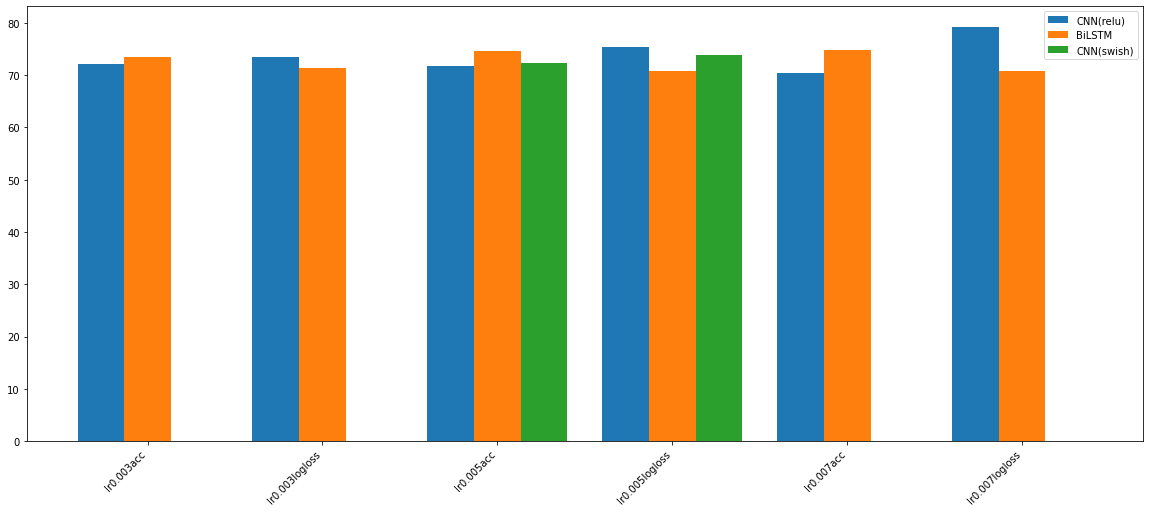

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,8))
topics = ['lr0.003acc', 'lr0.003logloss', 'lr0.005acc', 'lr0.005logloss', 'lr0.007acc','lr0.007logloss']
value_a = list(acclogloss['CNN(relu)'])
value_b = list(acclogloss['BiLSTM'])
value_c = list(acclogloss['CNN(swish)'])

def create_x(t, w, n, d):
    return [t*x + w*n for x in range(d)]
value_a_x = create_x(3,0.8,1,6)
value_b_x = create_x(3,0.8,2,6)
value_c_x = create_x(3,0.8,3,6)

ax = plt.subplot()
ax.bar(value_a_x, value_a)
ax.bar(value_b_x, value_b)
ax.bar(value_c_x, value_c)


middle_x = [(a+b+c)/3 for (a,b,c) in zip(value_a_x, value_b_x, value_c_x)]
ax.set_xticks(middle_x)
#ax.set_xticklabels(topics)
ax.set_xticklabels(topics, rotation=45, ha='right')
plt.legend(['CNN(relu)', 'BiLSTM','CNN(swish)'])
plt.show()

정확도는 클수록, log_loss는 작을수록 좋다.

따라서 모든 learning rate에서 Bi-Lstm이 CNN보다 성능이 좋은 것을 확인할 수 있다.

CNN에서 활성화 함수 swish와 relu를 나눠서 비교했을 때, swish일 때가 좋은 결과를 보여준다.